In [1]:
!apt-get install graphviz
!pip install graphviz

zsh:1: command not found: apt-get


In [2]:
#@title Imports

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Latex
from probability_trees import MinCut, Critical, PTree
from itertools import combinations

### Rock Throwing Example

In [3]:
def rock_throw_example(bvar):
    # bvar contains a dictionary of bound variables. 
    if 'SuzyThrow' not in bvar:
        return suzy_throws_randomly(p=0.5)
    if 'BillyThrow' not in bvar:
        return billy_throws_randomly(p=0.5)
    if 'SuzyHits' not in bvar:
        return suzy_hits_if_throws( bvar['SuzyThrow'] )
    if 'BillyHits' not in bvar:
        return billy_hits_if_throws_and_suzy_no( bvar['SuzyHits'], bvar['BillyThrow'] )
    if 'WindowShatter' not in bvar:
        return window_shatters_if_hit( bvar['SuzyHits'],
                                                        bvar['BillyHits'] )
    return None

def suzy_throws_randomly( p = 0.5 ):
    return [(p,'SuzyThrow=Throw'), 
            (1-p,  'SuzyThrow=NoThrow')]


def billy_throws_randomly( p = 0.5 ):
    return [(p,'BillyThrow=Throw'), 
            (1-p,  'BillyThrow=NoThrow')] 

def suzy_hits_if_throws( suzy_throw ):
    if suzy_throw == 'Throw':
        return [(1,'SuzyHits=Hit'),
                (0,'SuzyHits=NoHit'),
                ]
    else:
        return [(0,'SuzyHits=Hit'),
                (1,'SuzyHits=NoHit'),
                ] 

def billy_hits_if_throws_and_suzy_no( suzy_hit, billy_throw ):
    if suzy_hit == 'NoHit' and billy_throw == "Throw":
        return [(1,'BillyHits=Hit'),
                (0,'BillyHits=NoHit'),
                ]
    else:
        return [(0,'BillyHits=Hit'),
                (1,'BillyHits=NoHit'),
                ] 
def window_shatters_if_hit( suzy_hit, billy_hit ):
    if suzy_hit  == 'Hit' or billy_hit == 'Hit':
        return [(1,'WindowShatter=Shatter'),
                (0,'WindowShatter=NoShatter')]
    else:
        return [(0,'WindowShatter=Shatter'),
                (1,'WindowShatter=NoShatter')]


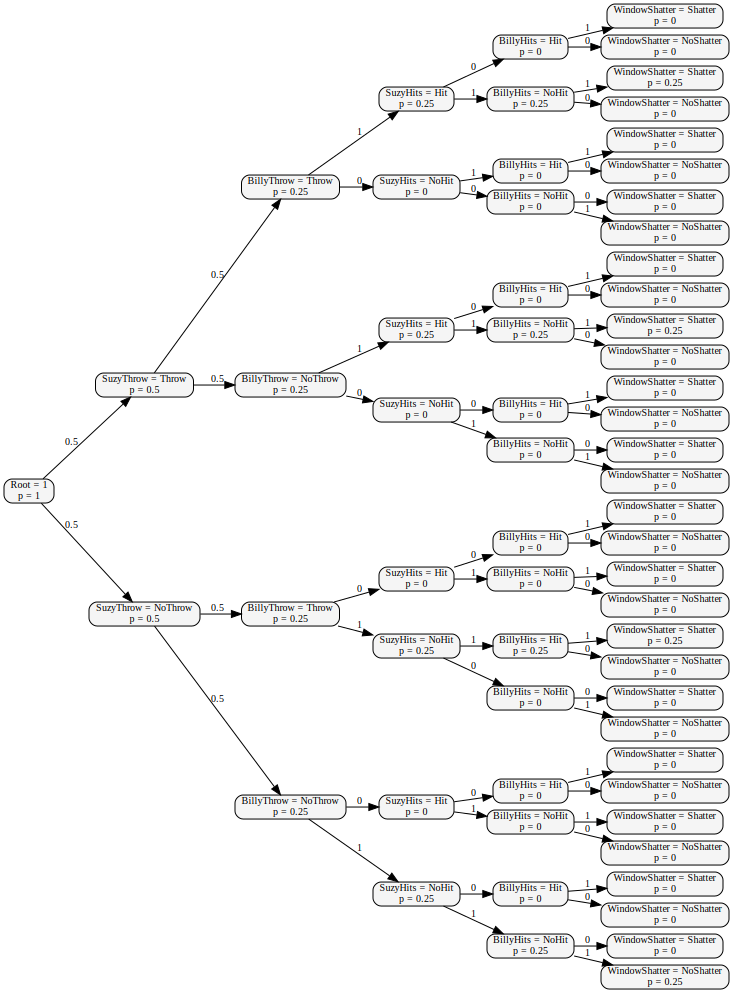

In [4]:
rock_throw = PTree.fromFunc(rock_throw_example, 'Root = 1')
display(rock_throw.show(show_prob=True))

In [5]:
root = rock_throw.get_root()
child = root.children[0][1]
print (root.children[0][1])
print (child)
print (child.assign)
print(rock_throw.rvs())

[('SuzyThrow', 'Throw')]
{'Root': ['1'], 'SuzyThrow': ['Throw', 'NoThrow'], 'BillyThrow': ['Throw', 'NoThrow'], 'SuzyHits': ['Hit', 'NoHit'], 'BillyHits': ['Hit', 'NoHit'], 'WindowShatter': ['Shatter', 'NoShatter']}


### HP Actual Causality

In [6]:
def all_two_partitions(items):
    subsets = list(powerset(items))[1:-1]
    partitions = []
    for ss in subsets:
        partitions.append((ss, list(set(items)-set(ss))))
    return partitions


        
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]


        
def gen_assign_dict(context):
    context_dict = {}
    for node in context:
        assign = node.assign[0]
        context_dict[assign[0]] = assign[1]
    return context_dict

        
def is_compatible(prob_tree, context_dict, assignments, phi, phi_context_val):
    """
    Check if phi occurs in the given context with the input set of assignments
    """
    #print("start is_compat \n")
    #print(assignments, phi, phi_context_val)
    
    is_compat = False
    root = prob_tree.get_root()
    current = root
    
    debug_trace_list = []
    
    while current.children and current.assign[0][0] != phi:
        in_assign = False
        #print ("\n") 
        for child_set in current.children:
            child = child_set[1]
            #print ("in child loop", child.assign[0], assignments)
            #print ("\n")
            if child.assign[0] in assignments:
                next_node = child
                in_assign = True
        if not in_assign:
            for child_set in current.children:
                prob = child_set[0]
                child = child_set[1]
                #print("in context loop", child.assign[0][0], child.assign[0][1], context_dict)
                #print ("\n")
                if context_dict[child.assign[0][0]] == child.assign[0][1] or prob == 1:
                    next_node = child
        current = next_node
        debug_trace_list.append(current.assign)
    
    if current.assign[0][0] == phi:
        is_compat = (current.assign[0][1] == phi_context_val)
    
    #print ("debug is_compat", debug_trace_list)
    #print("finished is_compat", current.assign, phi, phi_context_val, is_compat)
    #print ("\n")
    return is_compat


def get_not_assign(prob_tree, context_dict, var_list):
    not_var_assign = []
    #print(var_list)
    for var in var_list:
        var_all_vals = prob_tree.rvs()[var]
        for val in var_all_vals:
            if val != context_dict[var]:
                not_val = val
        not_var_assign.append((var, not_val))
    return not_var_assign

def get_assign(prob_tree, context_dict, var_list):
    var_assign = []
    for var in var_list:
        var_assign.append((var, context_dict[var]))
    return var_assign

        
def check_ac1(prob_tree, context_dict, X, phi):
    """
    X is a list of tuples of variables
    Phi is a tuple () variables
    context is list of a trace of nodes from prob_tree
    
    """
    x_in = True
    phi_in = True
    
    for x_assign in X:
        if context_dict[x_assign[0]] != x_assign[1]:
            x_in = False
    
    if context_dict[phi[0]] != phi[1]:
        phi_in = False
    
    return (x_in and phi_in)
        

    
def check_ac2(prob_tree, context, X, phi):
    """
    X and Phi are variables in the context of the form: like "SuzyThrow", "WindowShatter"
    context is a list of a trace of nodes from prob_tree
    prob_tree is the full prob tree
    
    """
    sat = False
    
    context_dict = gen_assign_dict(context)
    X_vars = [i[0] for i in X]
    X_u_vals = [context_dict[k] for k in X_vars]
    phi_var = phi[0]
    phi_u_val = phi[1]
    V = context_dict.keys()
    V_minus_x = list(set(V) - set(X_vars) - set([phi_var]))
    
    X_prime_assign = get_not_assign(prob_tree, context_dict, X_vars)

    for (Z, W) in all_two_partitions(V_minus_x):
        Z = Z + [phi_var]
        #print ("in ac2 partition loop", W) 
        #print ("\n")
        W_prime_assign = get_not_assign(prob_tree, context_dict, W)
        if not is_compatible(prob_tree, context_dict, X_prime_assign + W_prime_assign, phi_var, phi_u_val):
            if check_ac2_bo(prob_tree, context_dict, X_vars, Z, W, phi_var):
                print (f"ac2 true with: Z: {Z}, W: {W}")
                sat = True
    
    return sat



def check_ac2_bo(prob_tree, context_dict, X_vars, Z, W, phi_var):
    sat = True
    phi_u_val = context_dict[phi_var]
    Z_subsets = list(powerset(set(Z)))
    #print("start ac2 bo", W, Z_subsets)
    #print("\n")
    for Z_sub in Z_subsets:
        X_assign = get_assign(prob_tree, context_dict, X_vars)
        W_prime_assign = get_not_assign(prob_tree, context_dict, W)
        Z_sub_assign = get_assign(prob_tree, context_dict, Z_sub)
        #print ("in ac2 bo Z_sub loop", W, Z_sub)
        if not is_compatible(prob_tree, context_dict, X_assign + W_prime_assign + Z_sub_assign, phi_var, phi_u_val):
            #print ("ac2 bo is false", W, Z_sub)
            #print ("\n")
            sat = False
    #print ("end ac2 b0", W, sat)
    return sat



def check_ac3(prob_tree, context, X, phi):
    "Assume true for most cases since it's trivially satisfied in most toy examples"
    return True



def check_actual_cause(prob_tree, context, X_assign, phi_assign):
    print(f"start ac1 for {X_assign} cause {phi_assign}")
    context_dict = gen_assign_dict(context)
    ac1 = check_ac1(prob_tree, context_dict, X_assign, phi_assign)
    print(f"start ac2 for {X_assign} cause {phi_assign}")
    ac2 = check_ac2(prob_tree, context, X_assign, phi_assign)
    return (ac1, ac2)

In [7]:
root = rock_throw.get_root()
current = root
context_trace = []
U = [("SuzyThrow", "Throw"), ("BillyThrow", "Throw")]
while current.children:
    for (prob, child) in current.children:
        if child.assign[0] in U:
            next_node = child
        elif prob == 1:
            next_node = child
    context_trace.append(next_node)
    current = next_node
    
print (f"Context Trace: {gen_assign_dict(context_trace)} \n")
is_suzy_actual_cause = check_actual_cause(rock_throw, trace, [("SuzyThrow", "Throw")], ("WindowShatter", "Shatter"))
print (is_suzy_actual_cause)
is_billy_actual_cause = check_actual_cause(rock_throw, trace, [("BillyThrow", "Throw")], ("WindowShatter", "Shatter"))
print(is_billy_actual_cause)

Context Trace: {'SuzyThrow': 'Throw', 'BillyThrow': 'Throw', 'SuzyHits': 'Hit', 'BillyHits': 'NoHit', 'WindowShatter': 'Shatter'} 



NameError: name 'trace' is not defined